In [ ]:
import pandas as pd
import numpy as np
import itertools
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.model_selection import learning_curve, validation_curve, train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV, cross_validate, RepeatedStratifiedKFold
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import FunctionTransformer, StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
from sklearn.neighbors import LocalOutlierFactor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.svm import SVC
from scipy.stats import loguniform
from scipy.stats import loguniform, beta, uniform
from sklearn.metrics import confusion_matrix, classification_report, f1_score, roc_auc_score, accuracy_score, precision_recall_curve, PrecisionRecallDisplay, average_precision_score, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

from mlxtend.feature_selection import SequentialFeatureSelector as SFS

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import Pipeline as IMBPipeline

import missingno as msno

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

🌟 Introduction
Dataset used in this notebook aims to classificate stars, galaxies, and quasars based on their spectral characteristics.  The dataset is an imbalanced dataset. For this reason, Synthetic Minority Oversampling Technique (SMOTE) is used to eliminate the imbalance between classes. Outlier values are detected with the Local Outlier Factor and these values are removed from the dataset. In the 16-dimensional data set, the correlations of the features with the class label are checked and the features with a correlation greater than 0.16 are used for classification. In addition, the seaborn library and the yellow brick library are used for data visualization.

In [ ]:
df = pd.read_csv('/Users/yusufmehmet/Documents/Stellar Classification/star_classification.csv')
df.head()


,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 18 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   obj_ID       100000 non-null  float64
 1   alpha        100000 non-null  float64
 2   delta        100000 non-null  float64
 3   u            100000 non-null  float64
 4   g            100000 non-null  float64
 5   r            100000 non-null  float64
 6   i            100000 non-null  float64
 7   z            100000 non-null  float64
 8   run_ID       100000 non-null  int64  
 9   rerun_ID     100000 non-null  int64  
 10  cam_col      100000 non-null  int64  
 11  field_ID     100000 non-null  int64  
 12  spec_obj_ID  100000 non-null  float64
 13  class        100000 non-null  object 
 14  redshift     100000 non-null  float64
 15  plate        100000 non-null  int64  
 16  MJD          100000 non-null  int64  
 17  fiber_ID     100000 non-null  int64  
dtypes: float64(10), int64(7),

First of all the labels of the data are strings. We need to map them to unique integer numbers for each class. Then as the requariment of the project I need to distrube the data and then fill the data. Afterwards as a requariment I am going to drop the columns that doesnt serve anything or doesnt contribute to a classification task. For example: id's. 

In [ ]:
df["class"].value_counts()


class
GALAXY    59445
STAR      21594
QSO       18961
Name: count, dtype: int64

The class values are very unbalanced. This situation will create problems when we train the model .I am going to overcome this situation by sampling the class STAR and QSO and increasing their value to 59445.

Maping class label to integer numbers 

In [ ]:
# Map the 'class' column to numerical values
df['class'] = df['class'].map({'GALAXY': 0, 'STAR': 1, 'QSO': 2})

# Verify the mapping
df['class'].head(10)

0    0
1    0
2    0
3    0
4    0
5    2
6    2
7    0
8    0
9    1
Name: class, dtype: int64

PLlotting the class imbalance

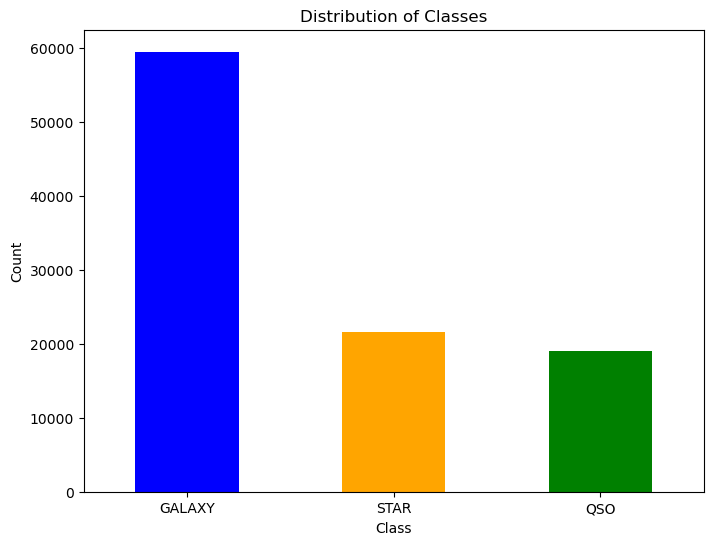

In [ ]:
# Plot the distribution of classes
class_counts = df['class'].value_counts()

plt.figure(figsize=(8, 6))
class_counts.plot(kind='bar', color=['blue', 'orange', 'green'])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of Classes')
plt.xticks(ticks=[0, 1, 2], labels=['GALAXY', 'STAR', 'QSO'], rotation=0)
plt.show()

Visulazition of data integrity

<Axes: >

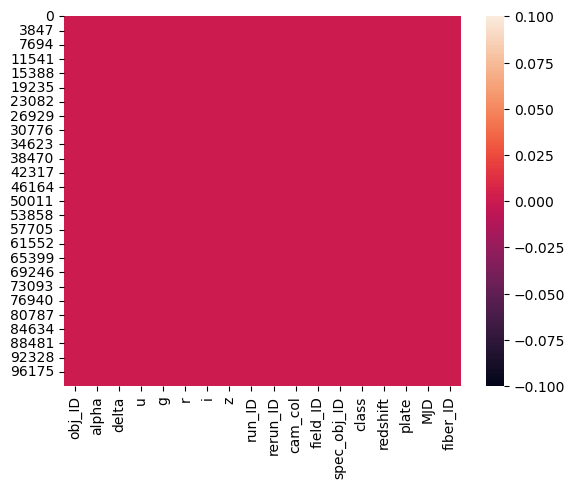

In [ ]:
sns.heatmap(df.isnull())

There are No NULL values it distortion in the data. AS a requariment of the project I am going the remove some values (except class labels) randomly. 

In [ ]:
def add_missing(col, amount):
    X = col.copy()
    size = amount if amount >= 1 else int(len(X) * amount)
    indexes = np.random.choice(len(X), size, replace = False )
    X[indexes] = np.nan
    return X
df.columns


Index(['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i', 'z', 'run_ID',
       'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'class', 'redshift',
       'plate', 'MJD', 'fiber_ID'],
      dtype='object')

In [ ]:
noisy_cols = ['obj_ID', 'alpha', 'delta', 'u', 'g', 'r', 'i','z', 'run_ID', 'rerun_ID', 'cam_col', 'field_ID', 'spec_obj_ID', 'redshift','plate', 'MJD', 'fiber_ID']

amount_of_noise = 0.06

for col in noisy_cols:
    if col in df.columns:
        df[col] = add_missing(df[col], amount_of_noise)
    else:
        print(f"Column {col} does not exist in the DataFrame.")
        

Visualization of missing values after distortion of the dataset

<Axes: >

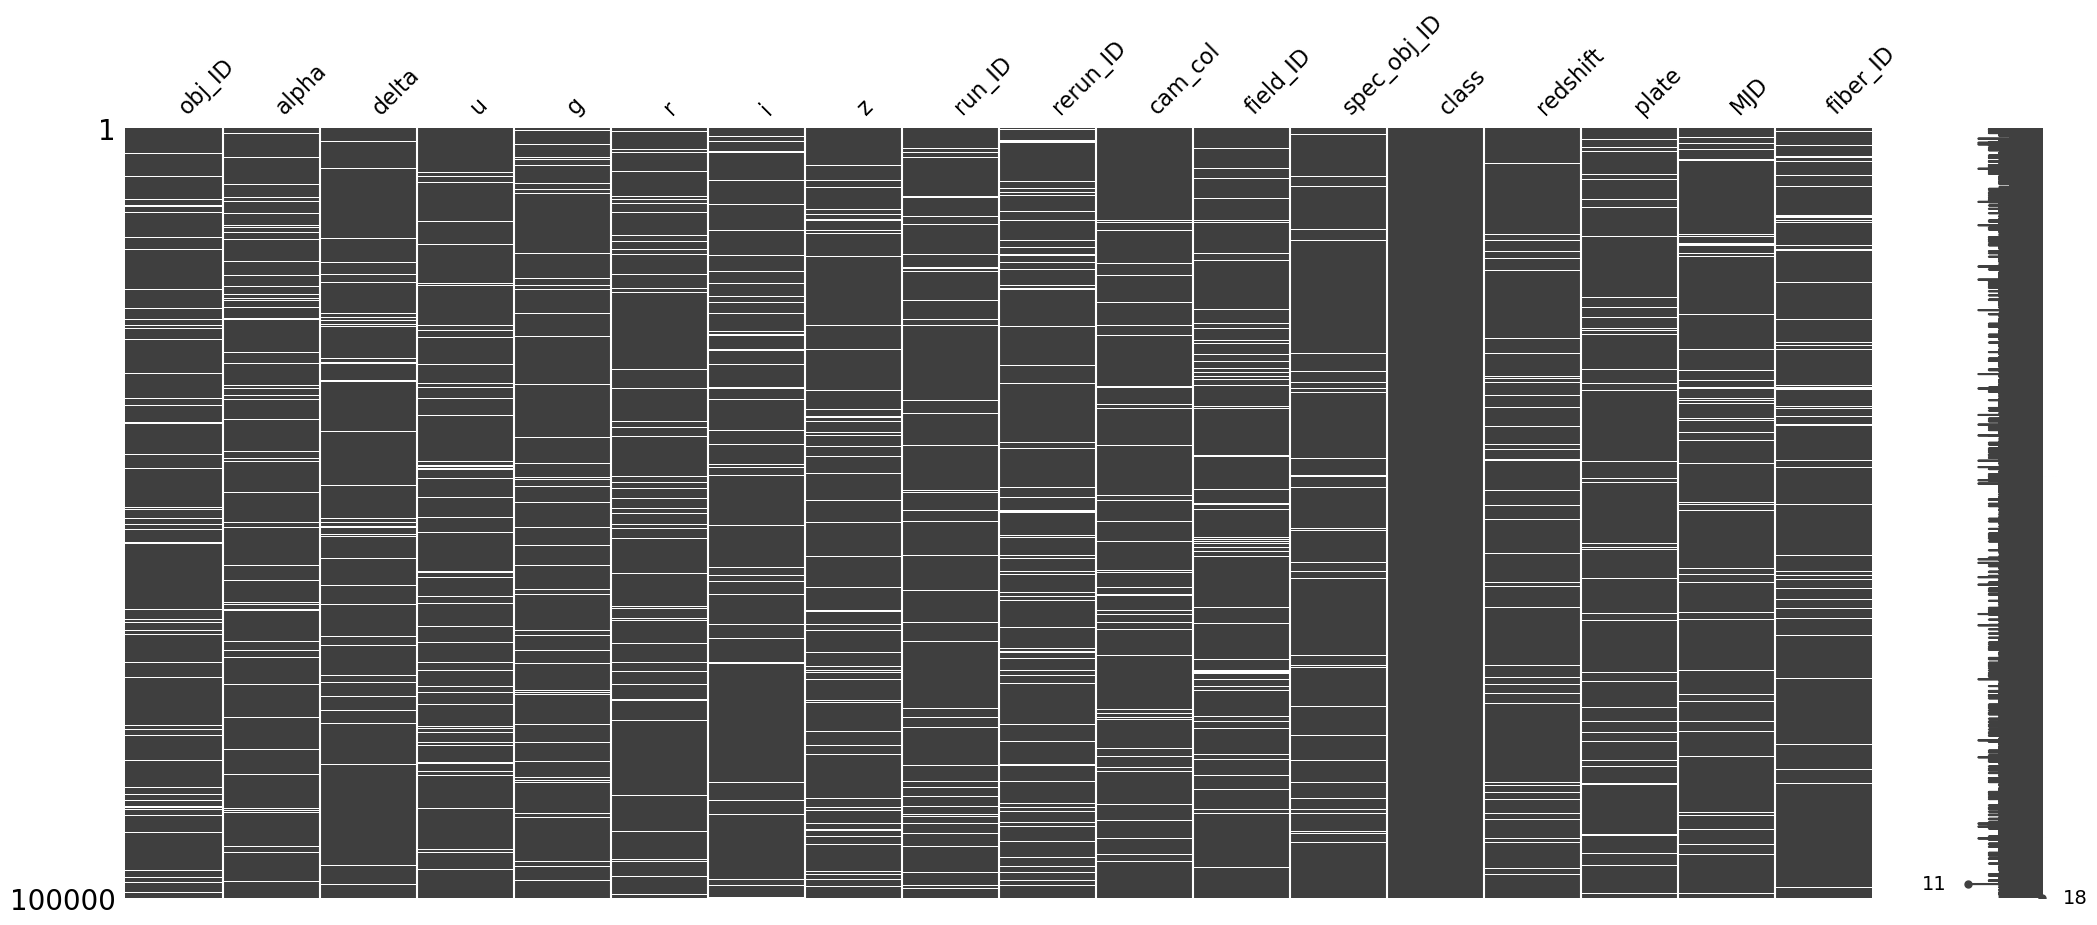

In [ ]:
msno.matrix(df)

In [ ]:
pipeline_age_fare = Pipeline([
    ('imp', KNNImputer(n_neighbors=5) ),
    ('scaler', StandardScaler() )
])


In [ ]:
df.isnull().sum()


obj_ID         6000
alpha          6000
delta          6000
u              6000
g              6000
r              6000
i              6000
z              6000
run_ID         6000
rerun_ID       6000
cam_col        6000
field_ID       6000
spec_obj_ID    6000
class             0
redshift       6000
plate          6000
MJD            6000
fiber_ID       6000
dtype: int64

Before handling the missing values, I am going to drop the columns that are already not usefull

In [ ]:
df = df.drop(['obj_ID','alpha','delta','run_ID','rerun_ID','cam_col','field_ID','fiber_ID'], axis = 1)
df.head(10)

,u,g,r,i,z,spec_obj_ID,class,redshift,plate,MJD
0,23.87882,22.27530,20.39501,19.16573,18.79371,6.543777e+18,0,0.634794,5812.0,56354.0
1,24.77759,22.83188,NaN,21.16812,21.61427,1.176014e+19,0,0.779136,10445.0,NaN
2,25.26307,22.66389,20.60976,19.34857,18.94827,5.152200e+18,0,0.644195,4576.0,55592.0
3,22.13682,23.77656,21.61162,20.50454,19.25010,1.030107e+19,0,0.932346,9149.0,58039.0
4,19.43718,17.58028,16.49747,15.97711,15.54461,6.891865e+18,0,0.116123,6121.0,56187.0
5,23.48827,23.33776,21.32195,20.25615,NaN,5.658977e+18,2,1.424659,5026.0,55855.0
6,21.46973,21.17624,20.92829,20.60826,20.42573,1.246262e+19,2,0.586455,11069.0,58456.0
7,22.24979,NaN,20.34126,19.48794,18.84999,6.961443e+18,0,0.477009,6183.0,56210.0
8,24.40286,NaN,NaN,19.46490,18.95852,7.459285e+18,0,0.660012,6625.0,56386.0
9,21.74669,20.03493,19.17553,18.81823,18.65422,2.751763e+18,1,-0.000008,2444.0,54082.0


Sofisticated method :Training a model to predict the missing values. Separeting the values as missing and non missing. Training with non missing values and predicting the missing values.

In [ ]:
def impute_missing_values(df, target_column):
    # Split the data into two parts: one with missing values and one without
    df_missing = df[df[target_column].isna()]
    df_no_missing = df[df[target_column].notna()]

    # Separate features and target
    X_train = df_no_missing.drop(columns=[target_column])
    y_train = df_no_missing[target_column]

    X_missing = df_missing.drop(columns=[target_column])

    # Create a pipeline with an imputer and the model
    model = make_pipeline(SimpleImputer(strategy='mean'), HistGradientBoostingRegressor())

    # Train the model
    model.fit(X_train, y_train)

    # Predict the missing values
    y_pred = model.predict(X_missing)

    # Fill in the missing values
    df.loc[df[target_column].isna(), target_column] = y_pred

    return df

# List of columns with missing values
columns_with_missing_values = [col for col in df.columns if df[col].isna().sum() > 0]

# Impute missing values for each column
for column in columns_with_missing_values:
    df = impute_missing_values(df, column)

# Verify that there are no missing values
print(df.isna().sum())

u              0
g              0
r              0
i              0
z              0
spec_obj_ID    0
class          0
redshift       0
plate          0
MJD            0
dtype: int64


Visualizing

<Axes: >

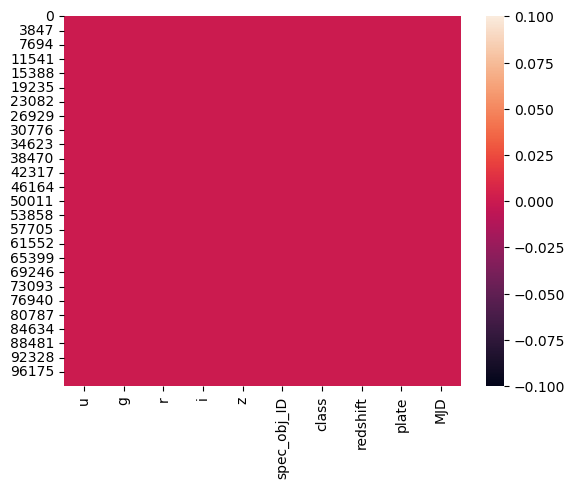

In [ ]:
sns.heatmap(df.isnull())


Simpler method: identifying individual needs of the columns. And applying different techiques to fill the values 
	
	1.	Continuous numerical columns (u, g, r, i, z, redshift):
	•	Mean/Median Imputation: If the data is normally distributed, filling missing values with the mean can be a good option. If the data is skewed, the median might be more appropriate.
    2.	Identifier columns (spec_obj_ID, plate, MJD):
	•	Mode Imputation: Since these columns are likely categorical identifiers, filling missing values with the most frequent value (mode) can be a simple and effective approach.
    1.	Fill continuous numerical columns using mean or median imputation.
	2.	Fill identifier columns using mode imputation.

In [ ]:
# Fill missing values for continuous numerical columns with median
# numerical_columns = ['u', 'g', 'r', 'i', 'z', 'redshift']
# for column in numerical_columns:
#     df[column].fillna(df[column].median(), inplace=True)

# # Fill missing values for identifier columns with mode
# identifier_columns = ['spec_obj_ID', 'plate', 'MJD']
# for column in identifier_columns:
#     df[column].fillna(df[column].mode()[0], inplace=True)

# # Check if there are any missing values left
# df.isnull().sum()

IMPLEMENTATION WITH PIPELINE

In [ ]:
# Identify numerical and categorical columns
# numerical_columns = ['u', 'g', 'r', 'i', 'z', 'redshift']
# identifier_columns = ['spec_obj_ID', 'plate', 'MJD']

# # Create an imputer for numerical columns (median imputation)
# numerical_imputer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median'))
# ])

# # Create an imputer for identifier columns (mode imputation)
# identifier_imputer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='most_frequent'))
# ])

# # Combine both imputers into a column transformer
# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numerical_imputer, numerical_columns),
#         ('id', identifier_imputer, identifier_columns)
#     ]
# )

# # Apply the transformations to the dataframe
# df[numerical_columns + identifier_columns] = preprocessor.fit_transform(df)

# # Verify that there are no missing values left
# missing_values_after = df.isnull().sum()
# print("Missing values after imputation:\n", missing_values_after)

DETECTING OUTLIERS

Detecting outliers refers to identifying data points that are significantly different from the majority of the data in a dataset. Outliers can be indicative of measurement errors, experimental errors, or they may be valid observations that are simply rare or unusual. Detecting and handling outliers is crucial because they can skew statistical analyses and machine learning models, leading to incorrect conclusions or predictions.

In [ ]:
clf = LocalOutlierFactor()
y_pred = clf.fit_predict(df) 
x_score = clf.negative_outlier_factor_
outlier_score = pd.DataFrame()
outlier_score["score"] = x_score

#threshold
threshold2 = -1.5                                            
filtre2 = outlier_score["score"] < threshold2
outlier_index = outlier_score[filtre2].index.tolist()
len(outlier_index)



15580

In [ ]:
#Dropping the outliers
df.drop(outlier_index, inplace=True)

FEATURE SELECTION

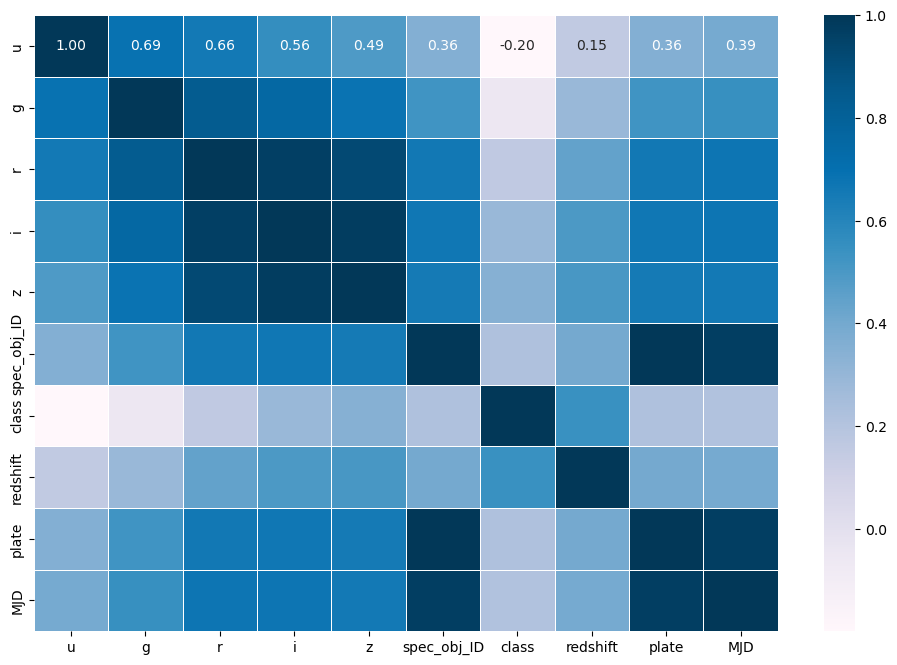

In [ ]:
f,ax = plt.subplots(figsize=(12,8))
sns.heatmap(df.corr(), cmap="PuBu", annot=True, linewidths=0.5, fmt= '.2f',ax=ax)
plt.show()

	1.	Strong Positive Correlations:
	•	u and g : These features have a strong positive correlation, indicating that as one increases, the other tends to increase as well.
	•	u and r  u and i, u and z : Similar strong positive correlations are seen between u and these other features, suggesting they likely measure related characteristics.
	•	g, r, i, and z also show strong inter-correlations , indicating these features are related and probably represent different bands of photometric data.
	2.	Moderate Correlations:
	•	class shows moderate positive correlation with redshift, suggesting that the classification may have some relationship with the redshift. 
	3.	Weak/Negative Correlations:
	•	u shows a weak negative correlation with spec_obj_ID (-0.22), which is not very significant but may indicate that spec_obj_ID doesn’t follow the same pattern as other numerical features.

COMMENTS;
since u, g, r, i, z show correlation we can merge them to one feature without losing some information. Thus we can run the algotihm efficiently. But since high correlation creates overfitting we can use PCA technique to improve the performance.
   

In [ ]:
corr = df.corr()
corr["class"].sort_values()

u             -0.199013
g             -0.051163
r              0.158071
MJD            0.210796
spec_obj_ID    0.220171
plate          0.220187
i              0.291000
z              0.347033
redshift       0.543134
class          1.000000
Name: class, dtype: float64

Showing the top correlation values for each feature

In [ ]:

# Calculate the correlation matrix
corr_matrix = df.corr()

# For each column, get the top 3 most correlated columns
top_correlations = {}
for column in corr_matrix.columns:
    top_correlations[column] = corr_matrix[column].sort_values(ascending=False).iloc[1:4]

# Convert the dictionary to a DataFrame for better readability
top_correlations_df = pd.DataFrame(top_correlations)

# Print the top correlations for each column
print("Top Correlations for Each Column:\n", top_correlations_df)

Top Correlations for Each Column:
                     u         g         r         i         z  spec_obj_ID  \
MJD               NaN       NaN       NaN       NaN       NaN     0.970849   
class             NaN       NaN       NaN       NaN       NaN          NaN   
g            0.686444       NaN  0.833541  0.752749  0.685878          NaN   
i            0.555587  0.752749  0.963403       NaN  0.972397     0.665556   
plate             NaN       NaN       NaN       NaN       NaN     0.999994   
r            0.656426  0.833541       NaN  0.963403  0.920503          NaN   
redshift          NaN       NaN       NaN       NaN       NaN          NaN   
spec_obj_ID       NaN       NaN       NaN       NaN       NaN          NaN   
u                 NaN  0.686444       NaN       NaN       NaN          NaN   
z                 NaN       NaN  0.920503  0.972397       NaN          NaN   

                class  redshift     plate       MJD  
MJD               NaN       NaN  0.970843       NaN 

Train Test Split

In [ ]:
X = df.drop(columns=['class'])
y = df['class']


In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y, random_state=30, shuffle=True)

Creating a pipeline for the model

In [ ]:
#since i already transformed the class column to numerical values, I am not going to use the onehotencoder
model_pipeline = IMBPipeline([
    ('sampler', SMOTE()),
    ('dim_reduction', PCA(n_components=0.8)),
    ('classifier', Perceptron())
])

Chosing model by trying all the possible combinations with different type of dimention reduction, classifier and sampling techniques

	1.	Logistic Regression:
	•	Advantages: Simple, interpretable, fast, works well with linear relationships.
	•	Disadvantages: May not perform well with complex or non-linear relationships.
	2.	Decision Trees:
	•	Advantages: Easy to interpret, handles non-linear relationships, works well with mixed data types.
	•	Disadvantages: Prone to overfitting, especially with deep trees.
	3.	Random Forest:
	•	Advantages: Reduces overfitting by averaging multiple trees, handles non-linear relationships, robust to noise.
	•	Disadvantages: Less interpretable, can be computationally expensive with large datasets.
	4.	Gradient Boosting Machines (GBM):
	•	Advantages: High predictive accuracy, handles non-linear relationships, can work well with a variety of data types.
	•	Disadvantages: Can be slow to train, sensitive to hyperparameters.
	5.	Support Vector Machines (SVM):
	•	Advantages: Effective in high-dimensional spaces, robust to overfitting in high-dimensional space.
	•	Disadvantages: Computationally intensive, less effective with large datasets, requires careful tuning of hyperparameters.
	6.	Neural Networks:
	•	Advantages: Highly flexible, capable of modeling complex patterns, state-of-the-art performance in many tasks.
	•	Disadvantages: Requires large amounts of data, computationally expensive, less interpretable.
	7.	K-Nearest Neighbors (KNN):
	•	Advantages: Simple, no training phase, effective with small datasets.
	•	Disadvantages: Computationally expensive during prediction, sensitive to irrelevant features and the scale of data.

In [ ]:
sampler_configs = [
    {
        'sampler':[None],# The element is bypassed
    },
    {
        'sampler':[SMOTE(n_jobs=-1)],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    },
    {
        'sampler':[RandomOverSampler()],
        'sampler__sampling_strategy':['minority', 1.2, 0.9, 0.7]
    }
]

dim_reduction_configs = [
    {
        'dim_reduction': [None]
    },
    {
        'dim_reduction': [PCA()],
        'dim_reduction__n_components': [0.5, 0.7, 0.9]
    },
    {
        'dim_reduction': [LDA()]
    },
    {
        'dim_reduction': [SFS(estimator=Perceptron(), cv = None, scoring = 'f1')],
        'dim_reduction__estimator': [Perceptron(), LogisticRegression()],
        'dim_reduction__k_features' : [5,7,10]  
    }
]

classifier_configs = [
    {
        'classifier__eta0' : loguniform(0.001,100),
        'classifier': [Perceptron()] ,
        'classifier__max_iter': [1,5,10,15,50,100] ,
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [LogisticRegression(multi_class='ovr', solver='saga')], # One-vs-Rest (OVR) Strategy
        'classifier__C' : loguniform(0.001,100),
        'classifier__penalty': ['l1','l2'],
        'classifier__class_weight' : [None, 'balanced']

    },
    {
        'classifier': [KNeighborsClassifier()],
        'classifier__n_neighbors': [3,5,7,9]
    },
    {
        'classifier' : [RandomForestClassifier()],
        'classifier__n_estimators' : [10,50,100, 500]
    },
    {
        'classifier': [HistGradientBoostingClassifier()],
        'classifier__learning_rate': loguniform(0.01, 0.2),
        'classifier__max_iter': [100, 200, 300],
        'classifier__max_depth': [None, 3, 5, 7],
    },
 
]

In [ ]:
#LESS COMPACT WAY
# all_configs = [dict(itertools.chain(*(e.items() 
# for e in configuration))) 
# for configuration in 
# itertools.product(sampler_configs,dim_reduction_configs,classifier_configs)]

all_configs = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters = []
    for element in configuration:
        for item in element.items():
            all_parameters.append(item)
    all_configs.append(dict(all_parameters)) # by dict(all_parameters) we create a dict from a list of pairs (key:value)

In [ ]:
f'Number of all possible configurations: {len(all_configs)}'

'Number of all possible configurations: 60'

In [ ]:
rs = RandomizedSearchCV(model_pipeline,
    param_distributions=all_configs,
    n_iter=len(all_configs) * 5,
    n_jobs=-1,
    cv = 2,
    scoring='f1_macro'
)

In [ ]:
scores = cross_validate(rs, X_train, y_train, scoring='f1_macro',  cv = 5, return_estimator=True, verbose=3) # choosing f1_macro metric because it is a multiclass classification problem

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maxim

[CV] END ......................................., score=0.977 total time= 3.1min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.1min remaining:    0.0s
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximu

[CV] END ......................................., score=0.977 total time= 2.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  5.5min remaining:    0.0s
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/

[CV] END ......................................., score=0.977 total time= 5.5min


/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_stochastic_gradient.py:702: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is al

[CV] END ......................................., score=0.975 total time= 5.4min


/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/imblearn/over_sampling/_smote/base.py:345: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 a

[CV] END ......................................., score=0.974 total time= 1.8min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 18.2min finished


In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9768803073488078
----------
None
None
RandomForestClassifier() {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9774693098243769
----------
None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': Tru

As we can understand here the best out of the others is RandomForestClassifier without any sampling or dimensional reduction need

In [ ]:
for estimator in scores['estimator']:
    pred_train = estimator.best_estimator_.fit(X_train, y_train)
    pred_train = estimator.best_estimator_.predict(X_train)
    pred_test = estimator.best_estimator_.predict(X_test)
    f1_train = f1_score(y_train, pred_train,average='weighted' )
    f1_test = f1_score(y_test, pred_test,average='weighted')
    print(f'F1 on training set:{f1_train}, F1 on test set:{f1_test}')

F1 on training set:1.0, F1 on test set:0.9789859753117645
F1 on training set:1.0, F1 on test set:0.9784082152207004
F1 on training set:1.0, F1 on test set:0.9788730948298127
F1 on training set:1.0, F1 on test set:0.9788145863734851
F1 on training set:0.99998519288256, F1 on test set:0.9786297241129736


hyperparameter optmization

In [ ]:
sampler_configs = [
    {'sampler': [None]},
]

dim_reduction_configs = [
    {'dim_reduction': [None]},
]


classifier_configs = [
    {
        'classifier': [RandomForestClassifier()],
        'classifier__bootstrap': [True], 
        'classifier__ccp_alpha': [0.0], 
        'classifier__class_weight': [None],
        'classifier__criterion': ['gini'],
        'classifier__max_depth': [None],
        'classifier__max_features': ['sqrt'],
        'classifier__max_leaf_nodes': [None],
        'classifier__max_samples': [None],
        'classifier__min_impurity_decrease': [0.0],
        'classifier__min_samples_leaf': [1],
        'classifier__min_samples_split': [2],
        'classifier__min_weight_fraction_leaf': [0.0],
        'classifier__n_estimators': [500],
        'classifier__n_jobs': [None],
        'classifier__oob_score': [False],
        'classifier__random_state': [None],
        'classifier__verbose':[0],
        'classifier__warm_start': [False]
    }
]

In [ ]:

all_configs_best = []
for configuration in itertools.product(sampler_configs,dim_reduction_configs,classifier_configs):
    # Merging of three dictionary into one
    all_parameters_best = []
    for element in configuration:
        for item in element.items():
            all_parameters_best.append(item)
    all_configs_best.append(dict(all_parameters_best))

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    	
best_pip = IMBPipeline([
    ('sampler', SMOTE()),
    ('dim_reduction', PCA()),
    ('classifier', RandomForestClassifier())
])
gs = GridSearchCV(
        best_pip,
        param_grid=all_configs_best,
        n_jobs=-1,
        cv=5,
        scoring='f1_weighted'
    )
    
    # Perform the cross-validation inside the block as well
scores_gs = cross_validate(
        gs,
        X_train,
        y_train,
        scoring='f1_weighted',
        cv=5,
        return_estimator=True,
        verbose=3
    )

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END ......................................., score=0.980 total time= 3.6min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV] END ......................................., score=0.980 total time= 3.5min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.0min remaining:    0.0s


[CV] END ......................................., score=0.980 total time= 3.4min
[CV] END ......................................., score=0.978 total time= 3.5min
[CV] END ......................................., score=0.978 total time= 3.5min


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed: 17.4min finished


In [ ]:
for index, estimator in enumerate(scores_gs['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index])
    print('-'*10)

None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9768803073488078
----------
None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9774693098243769
----------
None
None
RandomForestClassifier(n_estimators=500) {

In [ ]:
for index, estimator in enumerate(scores['estimator']):
    print(estimator.best_estimator_.get_params()['sampler'])
    print(estimator.best_estimator_.get_params()['dim_reduction'])
    print(estimator.best_estimator_.get_params()['classifier'],estimator.best_estimator_.get_params()['classifier'].get_params())
    print(scores['test_score'][index]) 
    print('-'*10)

None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 500, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9768803073488078
----------
None
None
RandomForestClassifier() {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}
0.9774693098243769
----------
None
None
RandomForestClassifier(n_estimators=500) {'bootstrap': Tru

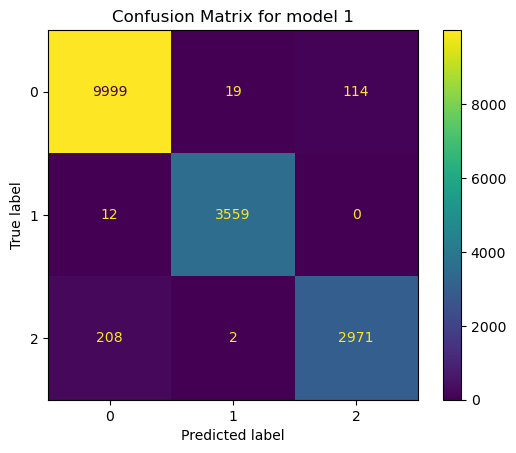

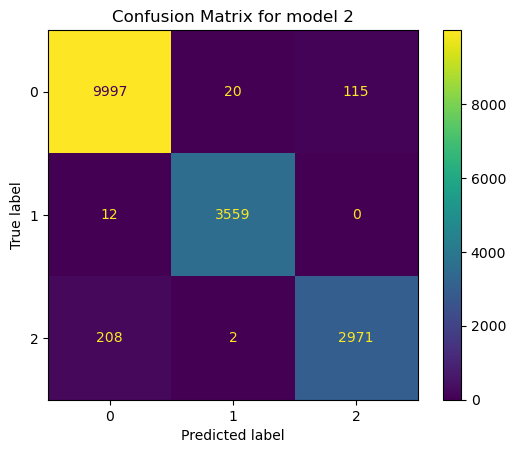

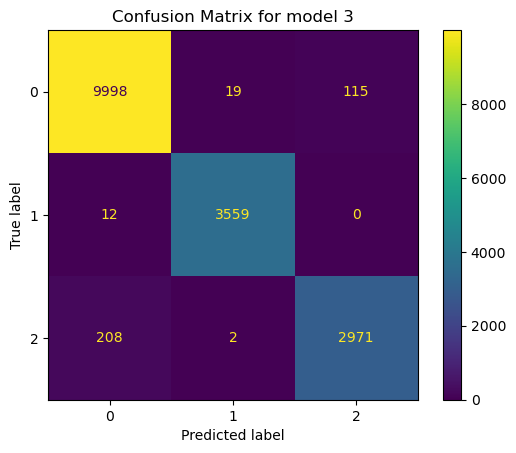

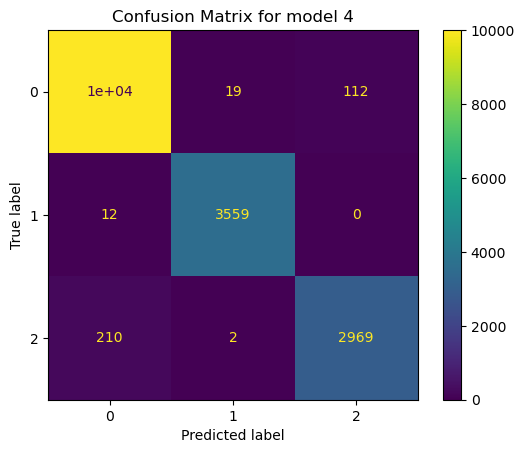

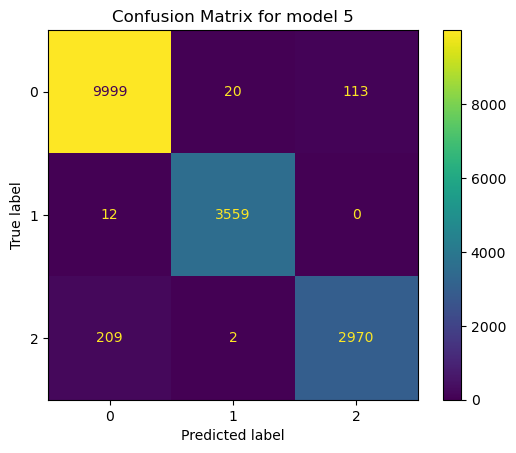

In [121]:
for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)
    predictions = best_model.predict(X_test)
    cm = confusion_matrix(y_test, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.title(f'Confusion Matrix for model {index+1}')
    plt.show()

In [122]:
for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)  # Fit the model on training data
    pred_probs = best_model.predict_proba(X_test)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test, pred_probs)
    disp = PrecisionRecallDisplay(precision=precision, recall=recall)
    disp.plot()
    plt.title(f'Precision-Recall Curve for model {index+1}')
    plt.show()

KeyboardInterrupt: 

In [ ]:
from sklearn.metrics import roc_curve, auc, RocCurveDisplay

for index, estimator in enumerate(scores_gs['estimator']):
    best_model = estimator.best_estimator_
    best_model.fit(X_train, y_train)  # Fit the model on training data
    pred_probs = best_model.predict_proba(X_test)[:, 1]
    
    fpr, tpr, thresholds = roc_curve(y_test, pred_probs)
    roc_auc = auc(fpr, tpr)
    
    # Plot the ROC Curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for model {index+1}')
    plt.legend(loc="lower right")
    plt.show()

    print(f'The AUC for model {index+1} is: {roc_auc:.2f}')

In [123]:
best_model = scores_gs['estimator'][3].best_estimator_


In [124]:
best_model['classifier'].get_params()


{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 500,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

Learning and Validation curve


In [126]:
train_sizes, train_scores, test_scores = learning_curve(best_model,
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes= [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
                                                       cv = 5,
                                                       n_jobs = -1,
                                                       scoring = 'f1_weighted',
                                                       shuffle = True)

(0.6, 1.03)

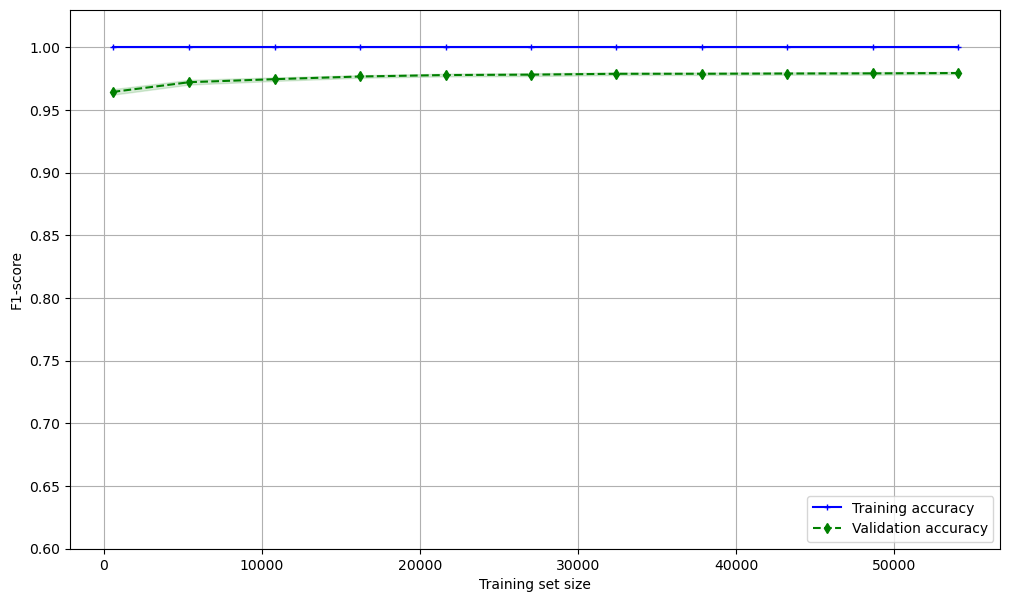

In [127]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

fig=plt.figure(figsize=(12,7))
ax = fig.add_subplot()

ax.plot(train_sizes, train_mean,
         color='blue', marker='+',
         markersize=5, label='Training accuracy')

ax.fill_between(train_sizes,
                 train_mean + train_std,
                 train_mean - train_std,
                 alpha=0.15, color='blue')

ax.plot(train_sizes, test_mean,
         color='green', linestyle='--',
         marker='d', markersize=5,
         label='Validation accuracy')

ax.fill_between(train_sizes,
                 test_mean + test_std,
                 test_mean - test_std,
                 alpha=0.15, color='green')

ax.grid()
ax.set_xlabel('Training set size')
ax.set_ylabel('F1-score')
ax.legend(loc='lower right')
ax.set_ylim([0.60, 1.03])